<a href="https://colab.research.google.com/github/callmemark/Correlation-of-Night-Air-Temperature-and-light-pollution-in-major-cities-in-the-Philippines/blob/main/Thesis_Proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Correlation of Night Air Temperature and light pollution in major cities in the Philippines </h1>


---
</br></br>




> Fernandez, Jaron Rix
</br>
Velmonte, Mark john A.









<h1>Preperation 1: Install Libraries</h1>

> Install neccesary libraries

In [ ]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install --upgrade pip --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install ipywidgets --quiet

# Install other libraries
!pip install splot --quiet
!pip install -U mgwr --quiet

#!pip freeze

<h1>Preperation 2: Import Libraries</h1>

> after installation we procced to import the libraries

In [3]:
#import libraries

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from google.colab import drive
from os import path, getcwd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

<h1> Preperation 3: Moun Drive </h1>

> To access data from google drive, We need to give permission to mount the drive and gain access to folders and files

In [4]:
#mount the google drive used
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Preperation 4: File Reference </h1>

> Create a dictionary to use for file path reference and for process automation

In [5]:
GPKG_DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/GPKG_FILES/"


gpkg_files_dict = {
    "Manila_City" : "Manila_City.gpkg",
    "Taguig_City" : "Taguig_City.gpkg",
    "Pasig_City" : "Pasig_City.gpkg",
    "Paranaque_City" : "Paranaque_City.gpkg",
    "Makati_City" : "Makati_City.gpkg",
    "LasPinas_City" : "LasPinas_City.gpkg",
    "Muntinlupa_City" : "Muntinlupa_City.gpkg",
    "Pasay_City" : "Pasay_City.gpkg",
    "Malabon_City" : "Malabon_City.gpkg",
    "Butuan_City" : "Butuan_City.gpkg",
    "NCR" : "NCR_region.gpkg"
    
}



DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/CSV_climactic_factors_dataset/"

CITY_NAME_2011_2020= [
    "Manila_City_2011-2020",
    "Taguig_City_2011-2020",
    "Pasig_City_2011-2020",
    "Paranaque_City_2011-2020",
    "Makati_City_2011-2020",
    "Las Pinas_City_2011-2020",
    "Muntinlupa_City_2011-2020",
    "Pasay_City_2011-2020",
    "Malabon_City_2011-2020",
    "Bututan_City_2011-2020"
]

CITY_NAME_2010_2010= [
    "Manila_City_2010-2010",
    "Taguig_City_2010-2010",
    "Pasig_City_2010-2010",
    "Paranaque_City_2010-2010",
    "Makati_City_2010-2010",
    "Las Pinas_City_2011-2020",
    "Muntinlupa_City_2010-2010",
    "Pasay_City_2010-2010",
    "Malabon_City_2010-2010",
    "Bututan_City_2010-2010"
]

LIGHTPOL_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/Light_pol_data/"

In [56]:
y_ext = ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
lpol_cname = [
  "manila_lpol_data_",
  "taguig_lpol_data_",
  "pasig_lpol_data_",
  "paranaque_lpol_data_",
  "makati_lpol_data_",
  "laspinas_lpol_data_",
  "muntinlupa_lpol_data_",
  "pasay_lpol_data_",
  "malabon_lpol_data_",
  "buttuan_lpol_data_",
]

dict_keys = ['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Bututan_City']
lpol_data_dict = {}


for _index in range(len(lpol_cname)):
  _avg_init_list = []
  for _year in y_ext:
    fname = lpol_cname[_index] + _year

    avg_val = np.average(np.array(pd.read_csv(LIGHTPOL_DIRECTORY + fname + ".csv", skiprows = 1))) # open csv || skip headder >> convert to numpy >> get avg
    _avg_init_list.append(avg_val)

  lpol_data_dict[dict_keys[_index]] = _avg_init_list
  print(dict_keys[_index], " Data Process complete")

lpol_data_df = pd.DataFrame(lpol_data_dict)

Manila_City  Data Process complete
Taguig_City  Data Process complete
Pasig_City  Data Process complete
Paranaque_City  Data Process complete
Makati_City  Data Process complete
Las Pinas_City  Data Process complete
Muntinlupa_City  Data Process complete
Pasay_City  Data Process complete
Malabon_City  Data Process complete
Bututan_City  Data Process complete


<h1>Preperation 5: Helper Function / Classes</h1>

> We created functions and classes for process that we know we will repeat 
<br>
> For modularity we adapt object oriented programming paradigm


In [54]:
# Helper functions and Classes
# from t-19 to t-4


def get_gpk_fpath(city_name_arg = str):
  try:
    return GPKG_DATASET_DIRECTORY + gpkg_files_dict[city_name_arg]
  except:
    raise Exception("error in get_gpk_fpath func | No City in dataset")
    

def get_file_path(city_name_arg):
  _fstr = DATASET_DIRECTORY + city_name_arg + ".csv"
  return _fstr

def read_and_comb_dataset(ds_n1 = str, ds_n2 = str, row_skip = 13):
  df_n1 = filter_data(pd.read_csv(ds_n1, skiprows=row_skip))
  df_n2 = filter_data(pd.read_csv(ds_n2, skiprows=row_skip))

  df_concat = [df_n1, df_n2]
  return pd.concat(df_concat)


def filter_data(data_frame_arg):
  modif_df = data_frame_arg
  year_in_data = np.array(data_frame_arg["YEAR"])

  if 2011 in year_in_data and 2010 in year_in_data:
    modif_df = data_frame_arg.drop(data_frame_arg[data_frame_arg["YEAR"] == 2011].index)
    #print("Removed 2011", 2010 in year_in_data)

  elif 2010 in year_in_data and 2020 in year_in_data:
    modif_df = data_frame_arg.drop(data_frame_arg[data_frame_arg["YEAR"] == 2010].index)
    #print("Removed 2010")

  elif 2021 in year_in_data and 2020 in year_in_data:
    modif_df = data_frame_arg.drop(data_frame_arg[data_frame_arg["YEAR"] == 2021].index)
    #print("Removed 2021")
  
  return modif_df



class ProcessMMreg():
  def __init__(self, City_Data, y_val_arg = "T2M"):
    self.city_data = City_Data
    self.y_val = y_val_arg

    self.city_df = pd.DataFrame(self.city_data)

    self.x = self.city_df.drop(columns = self.y_val)
    self.y = self.city_df[self.y_val]

    self.lr_model = LinearRegression()

  def run_standard_proc(self):
    self.split_train_test_data()
    self.fit_model()
    self.predict_data()
    self.get_prediction_plot()

  def split_train_test_data(self):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size = 0.3, random_state = 0)
    
  def fit_model(self):
    self.lr_model.fit(self.X_train, self.y_train)
  
  def predict_data(self):
    self.y_pred_train = self.lr_model.predict(self.X_train)

  def get_prediction_plot(self):
    plt.scatter(self.y_train, self.y_pred_train)
    #plt.xticks(self.y_pred_train)
    #plt.yticks(self.y_train)
    plt.show()

<h1>Procedure 1: Prepare Data</h1>

In this Section we prepare the data by filtering and selecting data that is neccesary to the research

In [35]:
# create a empty dictionary
nt_city_df_dict = {}

# loop through the list
for tf1, tf2 in zip(CITY_NAME_2010_2010, CITY_NAME_2011_2020):
  # creating str | expected result ex. Manila_City
  tf1_name = tf1.split("_")[0] + "_" + tf1.split("_")[1]
  tf2_name = tf2.split("_")[0] + "_" + tf2.split("_")[1]

  # check if combining data from the same city
  if tf1_name == tf2_name:
    dict_key = tf1_name
    # combine data from 2010-2020
    comb_df = read_and_comb_dataset(get_file_path(str(tf1)), get_file_path(str(tf2)))

    # filter data from t-19 to t-04
    nightime_data = comb_df.loc[(comb_df["HR"] <= 4) | (comb_df["HR"] >= 19)]

    # create new dictinary item and add new data
    nt_city_df_dict[dict_key] = nightime_data

  # raise custom error if data are from different city
  elif tf1_name != tf2_name:
    raise Exception("Error: City Names did not match | cannot proceed")

print(nt_city_df_dict.keys())

dict_keys(['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Bututan_City'])


In [36]:
# year 2011-2020
year_range = [i for i in range(2010, 2021)]
# climactic factors
df_params = ["PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR"]

# initialize empty dictionary
cities_yparam_avg_val = {}

# loop through the cities 
for city_fname in CITY_NAME_2011_2020: # or CITY_NAME_2010_2010 || Same value
  city_dict_key = city_fname.split("_")[0] + "_" + city_fname.split("_")[1]
  cities_yparam_avg_val[city_dict_key] = {}
  
  # loop through the climatic factors
  for param_name in df_params:
    # initialize new empty list every iteration
    initial_param_avg_list = []

    # loop through the year
    for _year in year_range:
      # get the average value of the current iterated climatic factor
      param_avg_val = np.average(np.array(nt_city_df_dict[city_dict_key].loc[nt_city_df_dict[city_dict_key]["YEAR"] == _year][param_name]))
      # appent to empty list
      initial_param_avg_list.append(param_avg_val)
      # add new dictionary key and its value
      cities_yparam_avg_val[city_dict_key][param_name] = np.array(initial_param_avg_list)



print(cities_yparam_avg_val.keys())

dict_keys(['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Bututan_City'])


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
months = [i for i in range(1,13)]
cities_yparam_avg_val_month = {}
months 
for city_fname in CITY_NAME_2011_2020: # or CITY_NAME_2010_2010 || Same value
  city_dict_key = city_fname.split("_")[0] + "_" + city_fname.split("_")[1]
  cities_yparam_avg_val_month[city_dict_key] = {}
  
  # loop through the climatic factors
  for param_name in df_params:
    # initialize new empty list every iteration
    initial_param_avg_list = []

    # loop through the year
    for _year in year_range:
      # get the average value of the current iterated climatic factor
      # add new dictionary key and its value
      
      for month in months:
        param_avg_val_month = np.average(np.array(nt_city_df_dict[city_dict_key].loc[nt_city_df_dict[city_dict_key]["MO"] == _year][param_name]))
        initial_param_avg_list.append(param_avg_val)
        cities_yparam_avg_val_month[city_dict_key][param_name] = np.array(initial_param_avg_list)




print(cities_yparam_avg_val_month.keys())

dict_keys(['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Bututan_City'])


In [38]:
Paranaque = pd.DataFrame(cities_yparam_avg_val["Paranaque_City"])
butuan_df = pd.DataFrame(cities_yparam_avg_val["Bututan_City"])
taguig_df = pd.DataFrame(cities_yparam_avg_val["Taguig_City"])
makati_df = pd.DataFrame(cities_yparam_avg_val["Makati_City"])
muntinlupa_df = pd.DataFrame(cities_yparam_avg_val["Muntinlupa_City"])
Manila_df = pd.DataFrame(cities_yparam_avg_val["Manila_City"])
Pasig_df = pd.DataFrame(cities_yparam_avg_val["Pasig_City"])
Las_Pinas_df = pd.DataFrame(cities_yparam_avg_val["Las Pinas_City"])
Pasay_df = pd.DataFrame(cities_yparam_avg_val["Pasay_City"])
Malabon_df = pd.DataFrame(cities_yparam_avg_val["Malabon_City"])





#NCR_geopckg.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
#NCR_geopckg.centroid.plot(ax=ax, c='black')


In [62]:
# (long, lat)
c1_coord = [(121.0198, 14.4793)] * 11
c2_coord = [(121.0198, 14.4793)] * 11
c3_coord = [(121.0509, 14.5176)] * 11
c4_coord = [(121.0244, 14.5547)] * 11
c5_coord = [(121.0415, 14.4081)] * 11
c6_coord = [(121.0244, 14.5547)] * 11
c7_coord = [(121.0244, 14.5547)] * 11
c8_coord = [(121.0415, 14.4081)] * 11
c9_coord = [(121.0244, 14.5547)] * 11
c0_coord = [(121.0244, 14.5547)] * 11


g_coords = c1_coord + c2_coord + c3_coord + c4_coord + c5_coord + c6_coord + c7_coord + c8_coord + c9_coord + c0_coord
cities_df = [Paranaque, butuan_df, taguig_df, makati_df, muntinlupa_df, Manila_df, Pasig_df, Pasay_df, Malabon_df, Las_Pinas_df]
lpol_data = [
    lpol_data_df["Manila_City"],
    lpol_data_df["Taguig_City"],
    lpol_data_df["Pasig_City"],
    lpol_data_df["Paranaque_City"],
    lpol_data_df["Las Pinas_City"],
    lpol_data_df["Muntinlupa_City"],
    lpol_data_df["Pasay_City"],
    lpol_data_df["Malabon_City"],
    lpol_data_df["Bututan_City"],
]


NCR_geopckg = get_gpk_fpath("NCR")
NCR_geopckg = gpd.read_file(NCR_geopckg)

lpol_df_data = pd.concat(lpol_data)
cities_df = pd.concat(cities_df)


cities_df["LongLat"] = g_coords
cities_df["lpol_avg"] = lpol_df_data

ValueError: ignored

In [57]:
lpol_data_df

,Manila_City,Taguig_City,Pasig_City,Paranaque_City,Makati_City,Las Pinas_City,Muntinlupa_City,Pasay_City,Malabon_City,Bututan_City
0,46.630000,19.124088,34.143791,23.833180,51.661333,17.061635,19.297283,51.597701,12.894366,0.312183
1,47.991667,19.860584,34.954902,25.893088,52.260667,17.276101,19.698370,51.886207,14.161972,0.358158
2,43.493333,20.115328,33.833987,26.141475,50.254000,16.967925,19.248913,52.611494,13.356338,0.386345
3,45.248333,22.378832,35.884314,29.184332,52.884000,17.608176,21.759783,58.752873,14.122535,0.434576
4,45.151666,23.172993,36.822876,29.920737,54.213333,17.661006,21.557065,57.750575,14.809859,0.447354
5,45.732222,25.737226,37.285621,32.114286,54.376000,18.646541,21.289130,57.943678,14.636620,0.463295
6,46.498889,24.744526,39.195425,33.394931,54.035333,19.444654,21.916304,60.072414,16.725352,0.488945
7,48.302778,25.638686,41.018301,35.129493,54.248000,20.649686,22.024457,61.898851,19.169014,0.511682
8,44.061666,25.420438,37.307189,31.624885,47.559333,19.498113,20.402174,55.197701,18.870423,0.514532


In [42]:
cities_df

,PS,T2M,QV2M,WS10M,PRECTOTCORR,LongLat
0,98.804746,24.232510,17.892011,2.221174,0.238148,"(121.0198, 14.4793)"
1,98.694436,23.772261,17.777405,2.574425,0.358428,"(121.0198, 14.4793)"
2,98.708347,23.972366,18.022033,2.376530,0.318817,"(121.0198, 14.4793)"
3,98.734901,24.154841,18.006301,2.286797,0.325263,"(121.0198, 14.4793)"
4,98.778425,23.899444,17.574564,2.362863,0.243915,"(121.0198, 14.4793)"
...,...,...,...,...,...,...
6,98.810331,24.395593,18.262426,2.335306,0.310530,"(121.0244, 14.5547)"
7,98.768307,24.248879,18.125679,2.311641,0.371299,"(121.0244, 14.5547)"
8,98.737726,23.973932,17.967973,2.491847,0.310737,"(121.0244, 14.5547)"
9,98.798614,24.159205,17.901000,2.353403,0.232973,"(121.0244, 14.5547)"


In [12]:
import random
samp_light_pol_val = []

for i in range(99):
  samp_light_pol_val.append(random.randint(240, 255))

samp_light_pol_val = pd.DataFrame(samp_light_pol_val)

In [28]:
g_y = cities_df['T2M'].values.reshape((-1,1)) #T2M
#g_y = samp_light_pol_val.values.reshape((-1,1))
g_X = cities_df[['QV2M', "PS", "WS10M", "PRECTOTCORR"]].values
g_coords = list(g_coords)

#g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
#g_y = g_y.reshape((-1,1))
#g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [29]:
g_X[np.isnan(g_X)] = 0
#g_X

In [30]:
g_y[np.isnan(g_y)] = 0
#g_y

In [36]:
gwr_selector = Sel_BW(g_coords, g_y, g_X, kernel = "gaussian", fixed = True, spherical=True) 
gwr_bw = gwr_selector.search(bw_min = 56)
gwr_bw

68.24

In [37]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [ ]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  99
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.245
Log-likelihood:                                                     156.661
AIC:                                                               -303.321
AICc:                                                              -300.408
BIC:                                                               -431.697
R2:                                                                   0.986
Adj. R2:                                                              0.985

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
gwr_results.params.shape

(99, 5)

In [ ]:
gwr_results.localR2[0:5]

array([[0.96547283],
       [0.96547283],
       [0.96547283],
       [0.96547283],
       [0.96547283]])

In [ ]:
gwr_filtered_t = gwr_results.filter_tvals()

In [ ]:
NCR_geopckg.shape

(9, 12)

In [ ]:
NCR_geopckg["Hello"] = 20
NCR_geopckg["Hello"].shape

(9,)

In [ ]:
NCR_geopckg["Hello"]

0    20
1    20
2    20
3    20
4    20
5    20
6    20
7    20
8    20
Name: Hello, dtype: int64

In [ ]:
gwr_results.params[:,1].shape

(99,)

In [ ]:
NCR_geopckg['gwr_x0'] = gwr_results.params[:0]
NCR_geopckg['gwr_x1'] = gwr_results.params[:1]
NCR_geopckg['gwr_x2'] = gwr_results.params[:2]
NCR_geopckg['gwr_x3'] = gwr_results.params[:3]
NCR_geopckg['gwr_x4'] = gwr_results.params[:4]


AttributeError: ignored

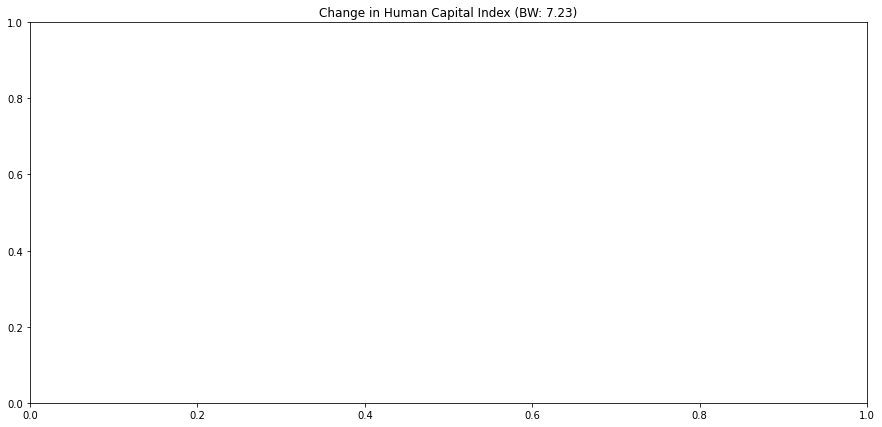

In [ ]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('Change in Human Capital Index (BW: ' + str(gwr_bw) +')', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = res_val['gwr_x2'].min() 
gwr_max = res_val['gwr_x2'].max() 
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
res_val.plot('gwr_x2', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,1] == 0).any():
    res_val[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

# Negative - west and north sumatra (part of riau)
#strong - south sumatra